# Imports

In [1]:
!pip install survlimepy jinja2 numpy==1.23.5

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import numpy as np
from sksurv.ensemble import RandomSurvivalForest
from survlimepy import SurvLimeExplainer
from survlimepy.load_datasets import RandomSurvivalData
import pandas as pd

# Generate data

In [11]:
# Generate data
n_points = 50
true_coef = [1, 1]
r = 1
center = [0, 0]
prob_event = 0.9
lambda_weibull = 10**(-6)
v_weibull = 2
n_features = len(true_coef)

rsd = RandomSurvivalData(
    center=center,
    radius=r,
    coefficients=true_coef,
    prob_event=prob_event,
    lambda_weibull=lambda_weibull,
    v_weibull=v_weibull,
    time_cap=None,
    random_seed=90,
)

# Train
X, time_to_event, delta = rsd.random_survival_data(num_points=n_points)
z = [(d, t) for d, t in zip(delta, time_to_event)]
y = np.array(z, dtype=[("delta", np.bool_), ("time_to_event", np.float32)])
total_row_train = X.shape[0]
print('total_row_train:', total_row_train)
unique_times = np.sort(np.unique(time_to_event))

total_row_train: 50


In [7]:
X

array([[ 5.85987789e-01,  1.70150200e-01],
       [-8.00424131e-01,  2.03022948e-01],
       [-3.30507761e-01, -6.39758812e-01],
       [-6.27460221e-01,  1.56983716e-01],
       [ 6.56020721e-01, -5.15702227e-01],
       [ 3.53688299e-01,  1.71785947e-02],
       [-6.05490662e-01,  5.77257197e-01],
       [-9.21986698e-01, -8.41181302e-02],
       [ 5.54477076e-01, -3.28861603e-01],
       [ 7.86223664e-03,  1.76912082e-02],
       [-3.22488964e-01, -1.66118783e-01],
       [ 8.52800534e-01,  3.31856239e-01],
       [-4.01893931e-01, -5.89029855e-01],
       [-2.52699630e-01, -7.75207235e-01],
       [-8.22005517e-01, -1.13168000e-01],
       [-5.19384639e-01,  6.45965648e-02],
       [-8.44380774e-01,  3.45459762e-01],
       [ 2.48767689e-01,  2.46842445e-02],
       [ 9.49941556e-01,  1.09308279e-01],
       [-2.89452403e-01,  1.91978397e-01],
       [-5.60414672e-01,  5.94132229e-03],
       [-5.98175562e-01,  9.08735369e-02],
       [ 5.45447324e-01, -5.10317792e-01],
       [-1.

In [8]:
# Point to explain
x_new = np.array([0.1, 0.1])

# Cox

In [ ]:
# Fit a Cox model
cox = CoxPHSurvivalAnalysis()
cox.fit(X, y)
print(cox.coef_)

In [ ]:
# SurvLime for COX
explainer_cox = SurvLimeExplainer(
    training_features=X,
    training_events=[tp[0] for tp in y],
    training_times=[tp[1] for tp in y],
    model_output_times=cox.event_times_,
    random_state=10,
)

b_cox = explainer_cox.explain_instance(
    data_row=x_new,
    predict_fn=cox.predict_cumulative_hazard_function,
    num_samples=1000,
    verbose=False,
)

explainer_cox.plot_weights()

# Random Survival Forest

In [12]:
rsf = RandomSurvivalForest().fit(X, y)

/home/onyxia/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


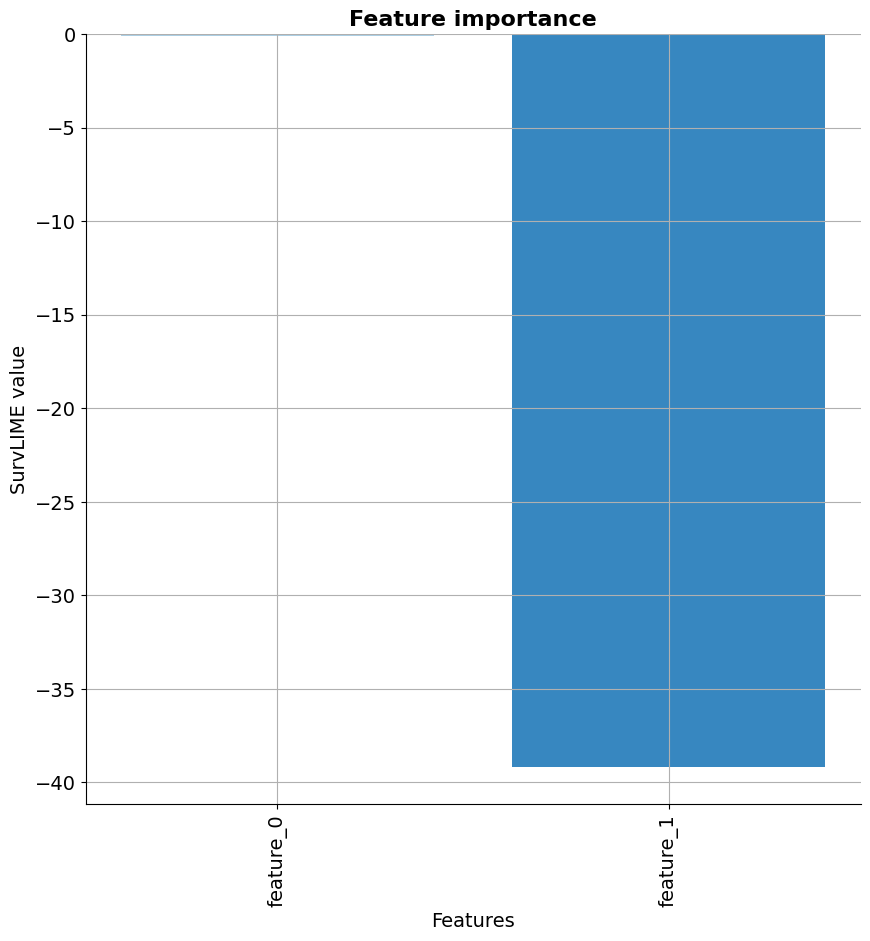

In [13]:
# SurvLime for RSF
explainer_rsf = SurvLimeExplainer(
    training_features=X,
    training_events=[tp[0] for tp in y],
    training_times=[tp[1] for tp in y],
    model_output_times=rsf.event_times_,
    random_state=10,
)

b_rsf = explainer_rsf.explain_instance(
    data_row=x_new,
    predict_fn=rsf.predict_cumulative_hazard_function,
    num_samples=1000,
    verbose=False,
)

explainer_rsf.plot_weights()

# xgbse

In [ ]:
# Transform the data in order to have the xgbse format
X_df = pd.DataFrame(X, columns = ['A', 'B'])

In [ ]:
xgbse = XGBSEKaplanNeighbors(n_neighbors=50)
xgbse.fit(X_df, y)

In [ ]:
explainer_xgbse = SurvLimeExplainer(
    training_features=X_df,
    training_events=[tp[0] for tp in y],
    training_times=[tp[1] for tp in y],
    model_output_times=xgbse.time_bins,
    random_state=10,
)

b_xgbse = explainer_xgbse.explain_instance(
    data_row=x_new,
    predict_fn=xgbse.predict,
    num_samples=1000,
    verbose=False
)

explainer_xgbse.plot_weights()

# DeepHit

In [ ]:
# Transform the data in order to have the DeepHit format
X_transformed = X.astype('float32')

In [ ]:
# Configure the net
in_features = X.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
output_bias = False
batch_size = 256
epochs = 512
get_target = lambda df: (df['duration'].values, df['event'].values)
verbose = True
num_durations = 50
labtrans = DeepHitSingle.label_transform(num_durations)
y_transformed = labtrans.fit_transform(time_to_event, delta)

In [ ]:
net_deep_hit = tt.practical.MLPVanilla(
    in_features,
    num_nodes,
    labtrans.out_features,
    batch_norm,
    dropout,
    output_bias=output_bias
)
deep_hit = DeepHitSingle(net_deep_hit, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
deep_hit.optimizer.set_lr(0.001)

# Train
log = deep_hit.fit(
    input=X_transformed,
    target=y_transformed,
    batch_size=batch_size,
    epochs=epochs,
    verbose=False
)

In [ ]:
explainer_deephit = SurvLimeExplainer(
    training_features=X_transformed,
    training_events=[tp[0] for tp in y],
    training_times=[tp[1] for tp in y],
    model_output_times=deep_hit.duration_index,
    random_state=10,
)

# Note that we use type_fn = "survival" since predict_fn is survival.
# Althought we use "survival", internally we transform everything to work with the cumulative hazard function.
# Therefore, the results must be interpret in the same way as if we were passing the cumulative hazard function.
b_deephit = explainer_deephit.explain_instance(
    data_row=x_new,
    predict_fn=deep_hit.predict_surv,
    type_fn = "survival",
    num_samples=1000,
    verbose=False,
)

explainer_deephit.plot_weights()

# DeepSurv
A per when this notebook is created, the version of `pycox` is 0.2.3. For DeepSuv model, the `predict_surv` return a mtriz of size $n \times m$, where $n$ is the number of individuals and $m$ is the number of unique times.

However, the function `predict_cumulative_hazards` returns a data frame of size $m \times n$. Therefore, if we want to use this function, we have to create a wrapper to transpose the output, since `SurvLIMEpy` needs the individuals in the rows. In this notebook, we show how to do that.

In [ ]:
y_df = pd.DataFrame(data={'duration': time_to_event, 'event': delta})
y_deepsurv = get_target(y_df)

In [ ]:
net_deep_surv = tt.practical.MLPVanilla(in_features, num_nodes, 1, batch_norm,dropout, output_bias=output_bias)
deep_surv = CoxPH(net_deep_surv, tt.optim.Adam())
deep_surv.optimizer.set_lr(0.001)
log = deep_surv.fit(
    input=X_transformed,
    target=y_deepsurv,
    batch_size=batch_size,
    epochs=epochs,
    verbose=False
)

In [ ]:
deep_surv.compute_baseline_hazards()

In [ ]:
def create_chf(fun):
    def inner(X):
        Y = fun(X)
        return Y.T
    return inner

predict_chf = create_chf(deep_surv.predict_cumulative_hazards)

In [ ]:
explainer_deepsurv = SurvLimeExplainer(
    training_features=X_transformed,
    training_events=[tp[0] for tp in y],
    training_times=[tp[1] for tp in y],
    model_output_times=unique_times,
    random_state=10,
)

b_deepsurv = explainer_deepsurv.explain_instance(
    data_row=x_new,
    predict_fn=predict_chf,
    num_samples=1000,
    verbose=False,
)

explainer_deepsurv.plot_weights()